In [1]:
import pandas as pd 
import os
import json
import mne
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
import numpy as np
from scipy.stats import pearsonr
from scipy.signal import resample

os.environ["MKL_NUM_THREADS"] = "72"
os.environ["OMP_NUM_THREADS"] = "72"
os.chdir('..')

# Load all the files
Producing this variables:
* `eeg_df` - EEG data itself in dataframe (furtere will be converted to mne)
* `eye_raw` - Eyetracking file
* `experiment_seq` - Experiment sequence in blocks

And a few more parameters:
* `sr` - sampling rate of EEG
* `chan_names` - Names of EEG channels as list
* `resolutions` - The resolutions values for EEG
* `experiment_duration` - The real length of the experiment in seconds

In [2]:
subject_id = 9
trial_id = 1

properties_path = f'Datasets/Data/S_{subject_id}/Trial_{trial_id}/EEG_Properties.json'
datablocks_path = f'Datasets/Data/S_{subject_id}/Trial_{trial_id}/EEG.csv'
experiment_path = f'Datasets/Data/S_{subject_id}/Trial_{trial_id}/Experiment.json'
eyetracker_path = f'Datasets/Data/S_{subject_id}/Trial_{trial_id}/Eyetracker.asc'
markers_path    = f'Datasets/Data/S_{subject_id}/Trial_{trial_id}/EEG_Markers.csv'

# Load and parse properties
with open(properties_path,'r') as f:
    props = json.load(f)
sr = props['sampling_interval']
chan_names  = props['channel_names']
resolutions = props['resolutions']

# Load and parse markers (if given)
if os.path.exists(markers_path) and os.path.getsize(markers_path) > 0:
    markers_df = pd.read_csv(markers_path, names=['block_id', 'position', 'points', 'channel', 'type_name', 'description'])
else:
    markers_df = None
    
# Load experiment sequence
with open(experiment_path,'r') as f:
    experiment_seq = json.load(f)
    experiment_duration = sum(block['content'].get('duration') for block in experiment_seq.values())

# Load eyetracker
eye_raw = mne.io.read_raw_eyelink(eyetracker_path, verbose=False)

# Load EEG itself
eeg_df = pd.read_csv(datablocks_path, header=None, names=['block_id']+chan_names)
eeg_df = eeg_df.replace(r';', '', regex=True).astype(float)
eeg_df["block_id"] = eeg_df["block_id"].astype(int)

print(f"EEG len:\t{len(eeg_df)} samples\nEyetracker len:\t{len(eye_raw)} samples")

EEG len:	1587320 samples
Eyetracker len:	1587544 samples


### Interpolate lost samples if neede:

In [3]:
if markers_df is not None:
    # Иногда, когда block_id указан не правильно, оно не отрабатывает
    try:
        # Get the lost samples per block
        markers_df['lost_samples'] = markers_df['description'].str.extract(r'(\d+)').astype(int)
        markers_df = markers_df[['block_id', 'position', 'lost_samples']]
    
        # Итерирование по markers_df
        for index, row in tqdm(markers_df.iterrows(), total=len(markers_df)):
            block_id = row['block_id']
            position = row['position']
            lost_samples = row['lost_samples']
        
            # Фильтрация строк для текущего block_id
            block_df = eeg_df[eeg_df['block_id'] == block_id]
        
            # Получение индекса начала блока
            start_idx = block_df.index[0]
        
            # Создание датафрейма с NaN значениями для вставки
            nan_df = pd.DataFrame({col: np.nan for col in eeg_df.columns}, index=[start_idx + position]*2)
            nan_df['block_id'] = block_id
        
            # Вставка nan_df в eeg_df
            eeg_df = pd.concat([eeg_df.iloc[:start_idx + position], nan_df, eeg_df.iloc[start_idx + position:]]).reset_index(drop=True)
    
        # Interpolation
        eeg_df_interpolated.loc[:, eeg_df.columns != 'block_id'] = eeg_df_interpolated.loc[:, eeg_df.columns != 'block_id'].interpolate(method='linear', limit_direction='both')
        eeg_df = eeg_df_interpolated
        eeg_df
        
    except:
        print(f"Failed to interpolate lost samples: {markers_df['lost_samples'].astype(int).sum()}")

### Trim the data to same length:

In [4]:
max_samples = sr * experiment_duration

# Trim EEG value to the experiment length
eeg_len = int(min(max_samples, len(eeg_df)-1))
eeg_df = eeg_df.iloc[:eeg_len]

# Trim EyeTracker to the experiment length
eye_len = int(min(eeg_len, eye_raw.n_times))
eye_raw.crop(tmax=(eye_len - 1) * eye_raw.info['sfreq']**-1)

print(f"EEG len:\t{len(eeg_df)} samples\nEyetracker len:\t{len(eye_raw)} samples\nExpected len:\t{int(max_samples)} samples")

EEG len:	1548000 samples
Eyetracker len:	1548000 samples
Expected len:	1548000 samples


# Deal with EEG

### Convert to MNE
`eeg_df` (pd.DataFrame) -> `eeg_raw` (mne.Dataset)

In [5]:
# Get only data
eeg_data = eeg_df.drop(columns=['block_id']).to_numpy().T  # Transpose: (n_channels, n_times)

# Scaling to µV (или хз что за единицы)
resolutions = np.array(resolutions).reshape(-1, 1)  # (n_channels, 1)
eeg_data = eeg_data * (resolutions * 0.01)  # Применяем масштабирование к каждому каналу (хз почему 0.01)

# Convert to mne
info = mne.create_info(ch_names=chan_names, sfreq=sr, ch_types='eeg')
eeg_raw = mne.io.RawArray(eeg_data, info)
montage = mne.channels.make_standard_montage('standard_1020')
eeg_raw.set_montage(montage)

eeg_raw

Creating RawArray with float64 data, n_channels=63, n_times=1548000
    Range : 0 ... 1547999 =      0.000 ...  1547.999 secs
Ready.


<RawArray | 63 x 1548000 (1548.0 s), ~744.1 MB, data loaded>

### Preprocessing:
Firstly preprocess all the data and save all blocks in `Data`

In [6]:

# ----------------------------------------------------------  Refferencing ------------------------------------------------------------------------------------------------------------------
eeg_raw.set_eeg_reference('average', projection=True)  # усредненная ссылка
eeg_raw.apply_proj()  # применим референтную проекцию



# ----------------------------------------------------------  Frequency Filtering -----------------------------------------------------------------------------------------------------------
eeg_raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')  # высоко- и низкочастотная фильтрация
eeg_raw.notch_filter(freqs=[50, 100])  # убрать сеть (50 Гц и гармоники)



# ---------------------------------------------------------- Remove eye artefacts ----------------------------------------------------------------------------------------------------------
# Rename bad_blink to blink (хз почему конфликтует)
new_descriptions = ['blink' if desc == 'BAD_blink' else desc for desc in eye_raw.annotations.description]
eye_raw.set_annotations(mne.Annotations(onset=eye_raw.annotations.onset, duration=eye_raw.annotations.duration, description=new_descriptions, ch_names=eye_raw.annotations.ch_names))
annotations = eye_raw.annotations

blink_times = annotations.onset[annotations.description == 'blink']
saccade_times = annotations.onset[annotations.description == 'saccade']

# Получим времена из eeg_raw
times = eeg_raw.times

# Создаем сигналы для морганий и саккад
blink_signal = np.zeros_like(times)
saccade_signal = np.zeros_like(times)

# Заполняем сигнал морганий
for annot in annotations[annotations.description == 'blink']:
    start = np.searchsorted(times, annot['onset'])
    end = np.searchsorted(times, annot['onset'] + annot['duration'])
    blink_signal[start:end] = 1

# Заполняем сигнал саккад
for annot in annotations[annotations.description == 'saccade']:
    start = np.searchsorted(times, annot['onset'])
    end = np.searchsorted(times, annot['onset'] + annot['duration'])
    saccade_signal[start:end] = 1

# Применяем ICA к EEG данным
ica = ICA(n_components=20, random_state=42, verbose=False)
ica.fit(eeg_raw)

# Получаем ICA источники
sources = ica.get_sources(eeg_raw)
sources_data = sources.get_data()  # shape: (n_components, n_times)

# Вычисляем корреляцию с сигналом морганий
blink_corrs = []
for i in range(sources_data.shape[0]):
    corr, _ = pearsonr(sources_data[i], blink_signal)
    blink_corrs.append(abs(corr))

# Вычисляем корреляцию с сигналом саккад
saccade_corrs = []
for i in range(sources_data.shape[0]):
    corr, _ = pearsonr(sources_data[i], saccade_signal)
    saccade_corrs.append(abs(corr))

# Определяем артефактные компоненты с помощью статистического порога (mean + 2*std)
blink_corrs = np.array(blink_corrs)
saccade_corrs = np.array(saccade_corrs)

mean_blink = np.mean(blink_corrs)
std_blink = np.std(blink_corrs)
blink_bads = [i for i, corr in enumerate(blink_corrs) if corr > mean_blink + 2 * std_blink]

mean_saccade = np.mean(saccade_corrs)
std_saccade = np.std(saccade_corrs)
saccade_bads = [i for i, corr in enumerate(saccade_corrs) if corr > mean_saccade + 2 * std_saccade]

# Объединяем список артефактных компонент
bads = list(set(blink_bads + saccade_bads))

# Исключаем артефактные компоненты
ica.exclude = bads

# Применяем ICA для очистки данных
eeg_raw = ica.apply(eeg_raw.copy(), verbose=False)


# TODO --------------------------------------------------------------------------------------------------------
# 1e-6 — соответствует ~1 μV. Если твои данные масштабированы иначе — нужно адаптировать.
# 500e-6 — это 500 μV, это очень большая амплитуда, в клинической EEG такие всплески чаще — мусор.
# === 4. Удаление выбросов с помощью автоматической разметки ===
# eeg_raw = eeg_raw.copy().annotate_flat(threshold=1e-6)  # плоские сигналы
# eeg_raw = eeg_raw.copy().annotate_amplitude(threshold=500e-6)  # слишком большие амплитуды

# TODO
# Bad channels
# eeg_raw.info['bads'] = ['F7', 'FT9']  # можно добавить вручную
# eeg_raw.interpolate_bads(reset_bads=True)

# Save all the experiment
out_path = f'./Generated/Data/S_{subject_id}/Trial_{trial_id}'
os.makedirs(out_path, exist_ok=True)
eeg_raw.save(f'{out_path}/EEG_clean.fif', overwrite=True)

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    4.0s finished


Fitting ICA to data using 63 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 48.7s.
    Applying projection operator with 1 vector (pre-whitener application)
Overwriting existing file.
Writing /home/leon/EEG-Visual-Experiment/Generated/Data/S_9/Trial_1/EEG_clean.fif


/tmp/ipykernel_11285/2769542253.py:98: RuntimeWarning: This filename (/home/leon/EEG-Visual-Experiment/Generated/Data/S_9/Trial_1/EEG_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_raw.save(f'{out_path}/EEG_clean.fif', overwrite=True)


Closing /home/leon/EEG-Visual-Experiment/Generated/Data/S_9/Trial_1/EEG_clean.fif
[done]


Using matplotlib as 2D backend.


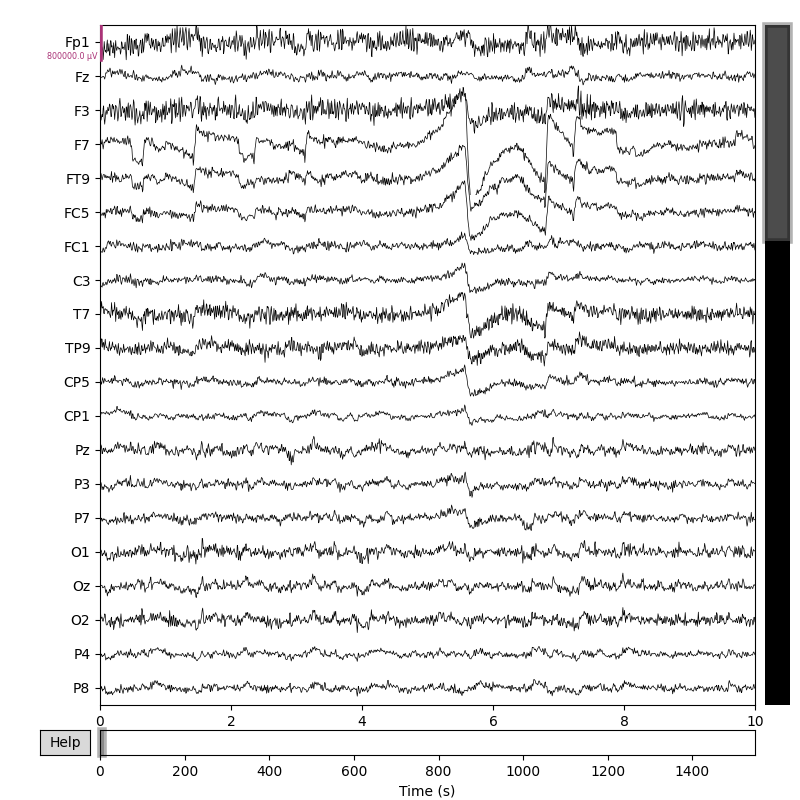

In [7]:
%matplotlib ipympl
eeg_raw.plot(scalings=0.4)
pass

# Deal With Eyetracker:

In [8]:
annotations = eye_raw.annotations
sfreq = eye_raw.info['sfreq']
n_times = eye_raw.n_times

# Создаём бинарные временные ряды
def create_event_channel(event_name):
    signal = np.zeros(n_times)
    for onset, duration, desc in zip(annotations.onset, annotations.duration, annotations.description):
        if desc == event_name:
            start = int(onset * sfreq)
            end = int((onset + duration) * sfreq)
            signal[start:end] = 1.0
    return signal

blink_signal = create_event_channel('blink')
saccade_signal = create_event_channel('saccade')

# Извлекаем и нормализуем x, y, pupil
def zscore(x):
    return (x - np.nanmean(x)) / np.nanstd(x)

eye_x = eye_raw.get_data(picks='xpos_left')[0]
eye_y = eye_raw.get_data(picks='ypos_left')[0]
eye_pupil = eye_raw.get_data(picks='pupil_left')[0]

# Нормализуем
# eye_x = zscore(eye_x)
# eye_y = zscore(eye_y)
# eye_pupil = zscore(eye_pupil)

# Собираем всё вместе
data = np.vstack([
    eye_x,
    eye_y,
    eye_pupil,
    blink_signal,
    saccade_signal
])

ch_names = ['EOG_x', 'EOG_y', 'EOG_pupil', 'EOG_blink', 'EOG_saccade']
ch_types = ['eog'] * len(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
eye_raw = mne.io.RawArray(data, info)

# Save all the experiment EOG
out_path = f'./Generated/Data/S_{subject_id}/Trial_{trial_id}'
os.makedirs(out_path, exist_ok=True)
eye_raw.save(f'{out_path}/EOG_clean.fif', overwrite=True, verbose='ERROR')

Creating RawArray with float64 data, n_channels=5, n_times=1548000
    Range : 0 ... 1547999 =      0.000 ...  1547.999 secs
Ready.


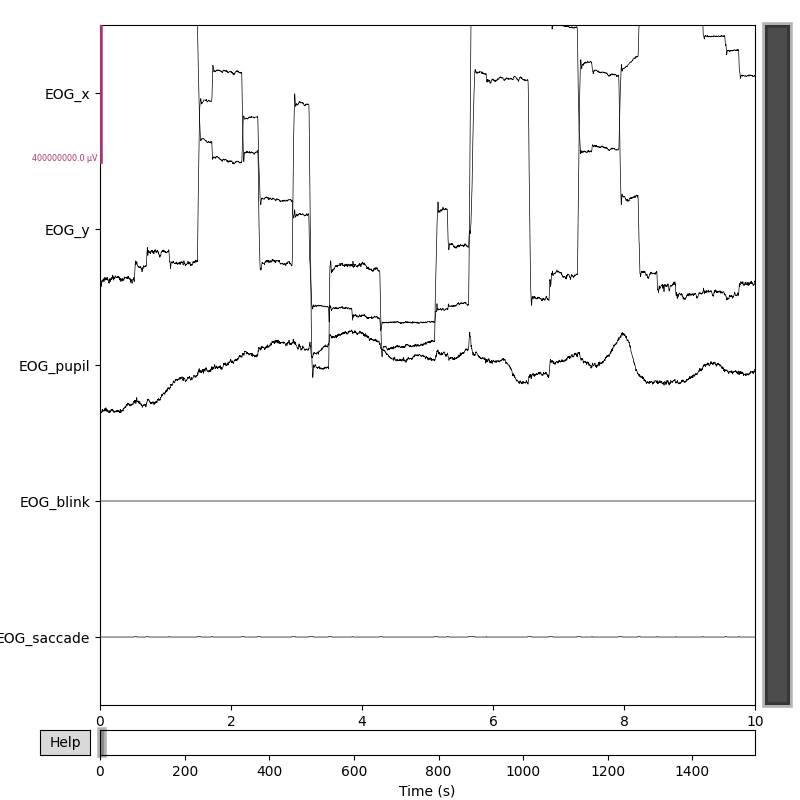

In [14]:
%matplotlib ipympl
eye_raw.plot(scalings=200)
pass

# Deal with Experiment.json

### Add pattern_id to the execution block
(Sorry for this shitty code)

In [10]:
# Инициализация переменных для отслеживания текущего паттерна и команды
current_pattern_type = None
current_pattern_id = None
command_state = None

# Итерация по блокам JSON
pattern_trio = []
for block_key, block_value in experiment_seq.items():
    if block_value['type'] == 'pattern':
        if len(pattern_trio) == 3:
            pattern_trio = []
            
        # Запоминаем тип и ID текущего паттерна
        current_pattern_type = block_value['content']['type']
        if current_pattern_type == 'geometric':
            current_pattern_id = block_value['content']['pattern_id']
        elif current_pattern_type == 'random':
            current_pattern_id = block_value['content']['seed']

        pattern_trio.append([current_pattern_type, current_pattern_id])
        
    elif block_value['type'] == 'command':
        # Запоминаем состояние команды
        command_state = int(block_value['content']['state']) - 1
        # Здесь мы могли бы проверить, что current_pattern_type и current_pattern_id не None,
        # но в данном случае это не обязательно, поскольку структура JSON описана жестко.
    elif block_value['type'] == 'execution':
        # Добавляем информацию о паттерне в блок execution
        block_value['content']['pattern_type'] = pattern_trio[command_state][0]
        block_value['content']['pattern_id'] = pattern_trio[command_state][1]

experiment_seq['Block_24'] # Example of updated execution

{'type': 'execution',
 'content': {'background_color': [80, 80, 80],
  'duration': 15,
  'fixation_poit_diam': 10,
  'pattern_type': 'geometric',
  'pattern_id': 5}}

### Add timestamps

In [11]:
timestamp = 0
for block in sorted(experiment_seq.keys(), key=lambda x: int(x.split('_')[1])):
    block_data = experiment_seq[block]
    block_data['timestamp'] = timestamp
    timestamp += block_data['content']['duration']

# Save updated experiment sequence .json file
experiment_path = f'./Generated/Data/S_{subject_id}/Trial_{trial_id}/Experiment.json'
with open(experiment_path, "w", encoding="utf-8") as f:
    json.dump(experiment_seq, f, indent=2, ensure_ascii=False)

experiment_seq['Block_24'] # Timestamps of updated execution

{'type': 'execution',
 'content': {'background_color': [80, 80, 80],
  'duration': 15,
  'fixation_poit_diam': 10,
  'pattern_type': 'geometric',
  'pattern_id': 5},
 'timestamp': 293}

Анимация сохранена: eog_animation_30fps.mp4


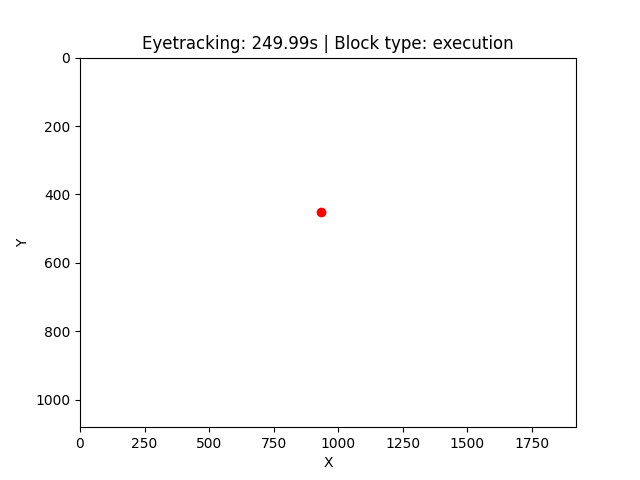

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Допустим, eye_sample — это Raw-объект с каналами 'x_pos' и 'y_pos'
eye_sample = eye_raw.copy().crop(tmax=250, include_tmax=False)

# Извлечем данные
data, times = eye_sample.copy().pick(['EOG_x', 'EOG_y']).get_data(return_times=True)

x = np.nan_to_num(data[0], nan=-100)
y = np.nan_to_num(data[1], nan=-100)

# Настройки
x_res, y_res = 1920, 1080  # или 960x540 если нужно меньше
step = 30  # рисуем каждый 30-й кадр
fps = 30   # сохраняем анимацию с 30 кадров в секунду
max_frames = len(x) // step  # можно ограничить, если надо

# Прореживаем и масштабируем
x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * x_res
y_scaled = (y - np.min(y)) / (np.max(y) - np.min(y)) * y_res
x_sub = x_scaled[::step]
y_sub = y_scaled[::step]
times_sub = times[::step]

# Интервал между кадрами в мс для отображения (но сохраняем как 30 fps)
interval_ms = 1000 / fps

# Настраиваем график
fig, ax = plt.subplots()
point, = ax.plot([], [], 'ro')
ax.set_xlim(0, x_res)
ax.set_ylim(0, y_res)
ax.invert_yaxis()
title = ax.set_title("Eyetracking: 0.00s")
ax.set_xlabel("X")
ax.set_ylabel("Y")


# Подготовим список блоков с интервалами времени и типом
blocks = []
block_items = list(experiment_seq.values())
for i, block in enumerate(block_items):
    start = block['timestamp']
    end = block_items[i + 1]['timestamp'] if i + 1 < len(block_items) else times[-1]
    blocks.append({'start': start, 'end': end, 'type': block['type']})
    

def update(i):
    current_time = times_sub[i] - times_sub[0]

    # Определяем текущий блок по времени
    block_type = "unknown"
    for block in blocks:
        if block['start'] <= current_time < block['end']:
            block_type = block['type']
            break

    point.set_data([x_sub[i]], [y_sub[i]])
    title.set_text(f"Eyetracking: {current_time:.2f}s | Block type: {block_type}")
    return point, title

ani = FuncAnimation(fig, update, frames=len(x_sub), interval=interval_ms, blit=True)

# Сохраняем в MP4
writer = FFMpegWriter(fps=fps)
ani.save("eog_animation_30fps.mp4", writer=writer)

print("Анимация сохранена: eog_animation_30fps.mp4")

# Prepare Training Data
Crop only Execution blocks +- 0.5 sec. Will be used for model training. Will be saved in `Data_Execution`.

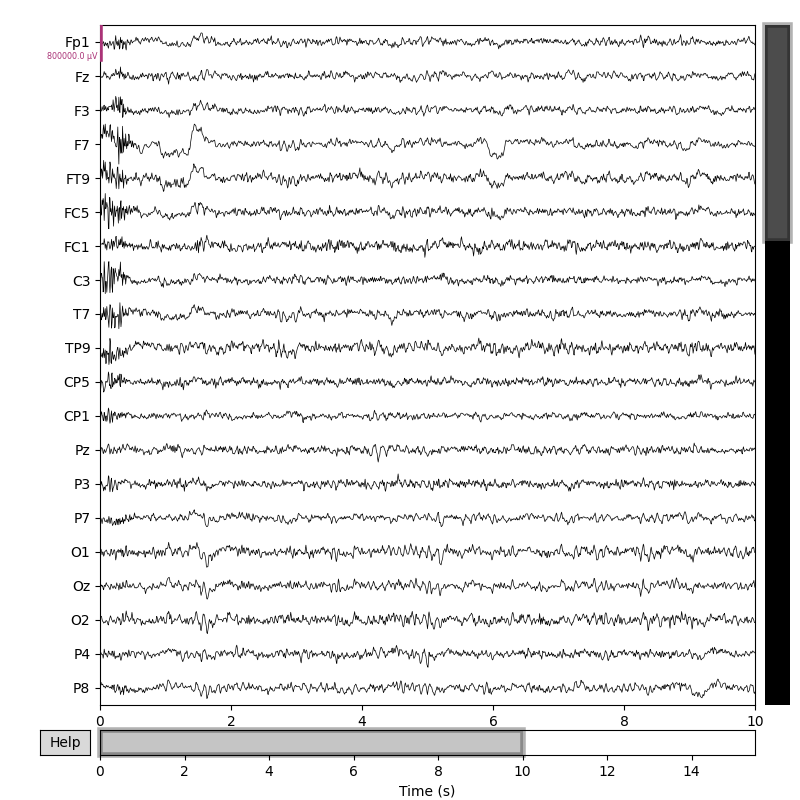

In [13]:
# Define execution_times as before
execution_times = [
    (block_data['timestamp'], block_data['content']['duration'])
    for block_data in experiment_seq.values()
    if block_data['type'] == 'execution'
]

t_plus = 0.5     # seconds
t_minus = 0.5   # seconds
expected_duration = int((t_minus + 15 + t_plus) * sr)  # in samples

execution_eeg_epochs = []
execution_eye_epochs = []

for i, (start_time, duration) in enumerate(execution_times):
    
    start_sample = start_time - t_minus  # in sec
    stop_sample = min((start_time + duration + t_plus), len(eeg_raw) / sr - 0.001) # in sec
    
    eeg_segment = eeg_raw.copy().crop(tmin=start_sample, tmax=stop_sample, verbose=False)
    eye_segment = eye_raw.copy().crop(tmin=start_sample, tmax=stop_sample, verbose=False)
    eeg_data = eeg_segment.get_data()  # shape: (n_channels, n_samples)
    eye_data = eye_segment.get_data()  # shape: (n_channels, n_samples)
    
    # Ресемплируем до expected_duration
    resampled_eeg_data = resample(eeg_data, expected_duration, axis=1)
    resampled_eye_data = resample(eye_data, expected_duration, axis=1)

    # Создаём новый RawArray с теми же метаданными
    new_eeg_segment = mne.io.RawArray(resampled_eeg_data, eeg_segment.info, verbose=False)
    new_eye_segment = mne.io.RawArray(resampled_eye_data, eye_segment.info, verbose=False)
    execution_eeg_epochs.append(new_eeg_segment)
    execution_eye_epochs.append(new_eye_segment)

    # Save
    out_path = f'./Generated/Data_Train/S_{subject_id}/Trial_{trial_id}/'
    os.makedirs(out_path, exist_ok=True)
    eeg_segment.save(f"{out_path}exec_EEG_{i+1}.fif", overwrite=True, verbose='ERROR')
    eye_segment.save(f"{out_path}exec_EOG_{i+1}.fif", overwrite=True, verbose='ERROR')


# Show last eeg_segment as an example
%matplotlib ipympl
eeg_segment.plot(scalings=0.4)
pass

Create a `labels.json` file from the `experiment_seq`

In [15]:
import json
import ast

# Загружаем геометрические паттерны как Python-объект из txt-файла
with open('./Supplementary/geometric_patterns.txt', 'r') as f:
    geometric_patterns = ast.literal_eval(f.read())

def gen_img(seed):
    seed = seed % 2 ** 32
    np.random.seed(seed)
    img = 1 - np.random.randint(0, 2, size=(6, 6))
    return img.tolist()

execution_blocks = [
    block_data
    for block_data in experiment_seq.values()
    if block_data['type'] == 'execution'
]

result = {"blocks": []}

for i, block in enumerate(execution_blocks, start=1):
    content = block["content"]
    pattern_type = content["pattern_type"]
    pattern_id = content["pattern_id"]

    block_entry = {
        "Exec_Block_Index": i,
        "type": pattern_type
    }

    if pattern_type == "geometric":
        block_entry["pattern_id"] = pattern_id
        block_entry["img"] = geometric_patterns[pattern_id]
    elif pattern_type == "random":
        block_entry["seed"] = pattern_id
        block_entry["img"] = gen_img(pattern_id)

    result["blocks"].append(block_entry)

# Сохраняем результат в файл labels.json
with open(f'{out_path}labels.json', 'w') as outfile:
    json.dump(result, outfile, indent=2)

# Show as an example one of the labels for block 5
result['blocks'][4]

{'Exec_Block_Index': 5,
 'type': 'geometric',
 'pattern_id': 10,
 'img': [[0, 0, 0, 1, 0, 0],
  [0, 0, 1, 0, 0, 0],
  [0, 1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1, 0],
  [0, 0, 0, 1, 0, 0],
  [0, 0, 1, 0, 0, 0]]}